In [5]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split

### 1. Loading the dataset

In [7]:
df = pd.read_excel("../dataset/premiums.xlsx")
df.head()

,Age,Gender,Region,Marital_status,Number Of Dependants,BMI_Category,Smoking_Status,Employment_Status,Income_Level,Income_Lakhs,Medical History,Insurance_Plan,Annual_Premium_Amount
0,26,Male,Northwest,Unmarried,0,Normal,No Smoking,Salaried,<10L,6,Diabetes,Bronze,9053
1,29,Female,Southeast,Married,2,Obesity,Regular,Salaried,<10L,6,Diabetes,Bronze,16339
2,49,Female,Northeast,Married,2,Normal,No Smoking,Self-Employed,10L - 25L,20,High blood pressure,Silver,18164
3,30,Female,Southeast,Married,3,Normal,No Smoking,Salaried,> 40L,77,No Disease,Gold,20303
4,18,Male,Northeast,Unmarried,0,Overweight,Regular,Self-Employed,> 40L,99,High blood pressure,Silver,13365


In [8]:
df.shape

(50000, 13)

In [9]:
df.columns

Index(['Age', 'Gender', 'Region', 'Marital_status', 'Number Of Dependants',
       'BMI_Category', 'Smoking_Status', 'Employment_Status', 'Income_Level',
       'Income_Lakhs', 'Medical History', 'Insurance_Plan',
       'Annual_Premium_Amount'],
      dtype='object')

In [10]:
df.columns = df.columns.str.replace(' ', '_').str.lower() ## snake case convention and removing spaces
df.head()

,age,gender,region,marital_status,number_of_dependants,bmi_category,smoking_status,employment_status,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount
0,26,Male,Northwest,Unmarried,0,Normal,No Smoking,Salaried,<10L,6,Diabetes,Bronze,9053
1,29,Female,Southeast,Married,2,Obesity,Regular,Salaried,<10L,6,Diabetes,Bronze,16339
2,49,Female,Northeast,Married,2,Normal,No Smoking,Self-Employed,10L - 25L,20,High blood pressure,Silver,18164
3,30,Female,Southeast,Married,3,Normal,No Smoking,Salaried,> 40L,77,No Disease,Gold,20303
4,18,Male,Northeast,Unmarried,0,Overweight,Regular,Self-Employed,> 40L,99,High blood pressure,Silver,13365


### 2. EDA & data cleaning

#### i. Handling na values

In [13]:
df.isna().sum()

age                       0
gender                    0
region                    0
marital_status            0
number_of_dependants      0
bmi_category              0
smoking_status           11
employment_status         2
income_level             13
income_lakhs              0
medical_history           0
insurance_plan            0
annual_premium_amount     0
dtype: int64

In [14]:
df.dropna(inplace = True) ## very few na as no of rows = 50k. we can just drop them.
df.isna().sum()

age                      0
gender                   0
region                   0
marital_status           0
number_of_dependants     0
bmi_category             0
smoking_status           0
employment_status        0
income_level             0
income_lakhs             0
medical_history          0
insurance_plan           0
annual_premium_amount    0
dtype: int64

#### ii. Handling duplicates

In [16]:
df.duplicated().sum() ##no duplicates

np.int64(0)

In [17]:
df.drop_duplicates(inplace=True) ## we can till keep the code because if tomorrow the file is updated and it has duplicaytes then we'll have handling code.
df.duplicated().sum()

np.int64(0)

In [18]:
df.describe()

,age,number_of_dependants,income_lakhs,annual_premium_amount
count,49976.000000,49976.000000,49976.000000,49976.000000
mean,34.591764,1.711842,23.021150,15766.810189
std,15.000378,1.498195,24.221794,8419.995271
min,18.000000,-3.000000,1.000000,3501.000000
25%,22.000000,0.000000,7.000000,8607.750000
50%,31.000000,2.000000,17.000000,13928.000000
75%,45.000000,3.000000,31.000000,22273.500000
max,356.000000,5.000000,930.000000,43471.000000


In [19]:
## max age = 356.000000, min number_of_dependants = -3, max income_lakhs = 930 (9.3 cr) | These are or can be outliers.  

#### iii. Data Cleaning: number_of_dependants

In [21]:
df[df.number_of_dependants<0].shape ## 73 values have no of dependents as negative

(72, 13)

In [22]:
df['number_of_dependants'][df.number_of_dependants < 0].unique() ## 72 rows have these values. Maybe +ve values converted to negative by mistake.

array([-3, -1])

In [23]:
df['number_of_dependants'] = abs(df['number_of_dependants'])

In [24]:
df.number_of_dependants.describe()  # now looking good

count    49976.000000
mean         1.717284
std          1.491953
min          0.000000
25%          0.000000
50%          2.000000
75%          3.000000
max          5.000000
Name: number_of_dependants, dtype: float64

#### iii. Data Cleaning: visualizing outliers

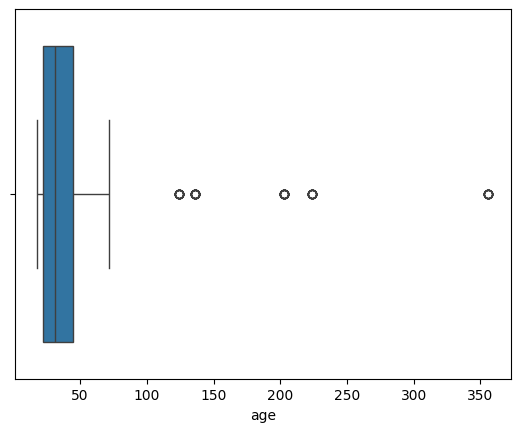

In [26]:
sns.boxplot(x = df['age'])
plt.show()

## Numeric Columns

### Univariate Analysis: Numeric Columns

In [29]:
## for all numeric columns

In [30]:
numeric_columns = df.select_dtypes(['float64','int64']).columns
numeric_columns

Index(['age', 'number_of_dependants', 'income_lakhs', 'annual_premium_amount'], dtype='object')

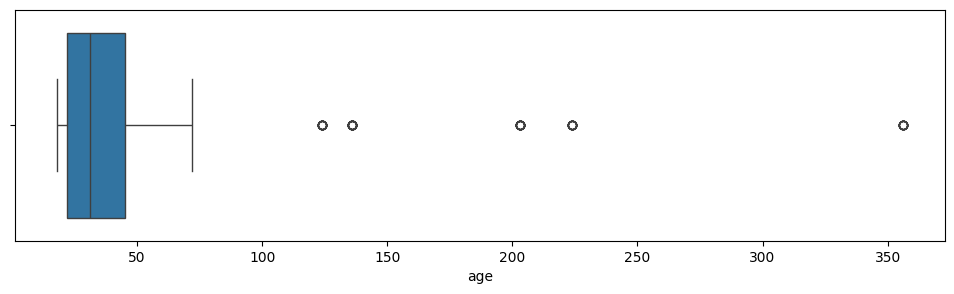

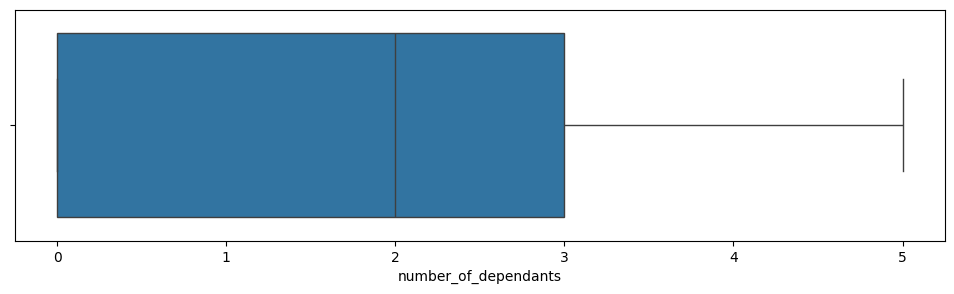

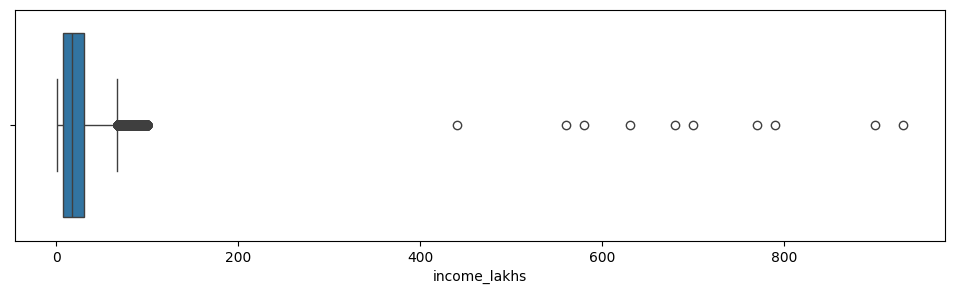

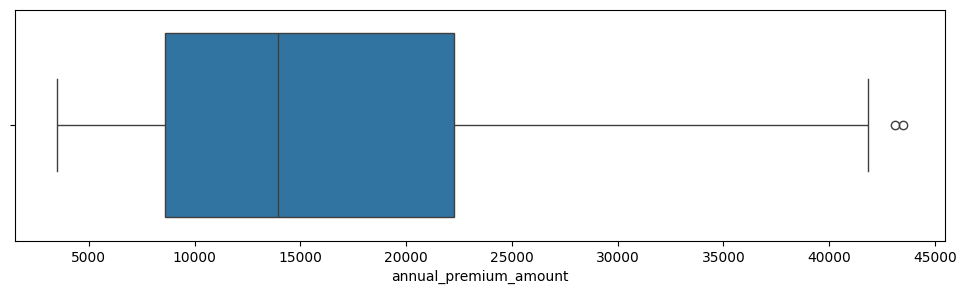

In [31]:
for col in numeric_columns:
    plt.figure(figsize=(12, 3)) 
    sns.boxplot(x=df[col])
    plt.show()

### iv. Outlier Treatment: Age Column

In [33]:
df['age'][df.age > 100].unique() 

array([224, 124, 136, 203, 356])

In [34]:
df1 = df[df.age<=100].copy() ## row filtering and then copying into a new df just for safety
df1.describe()  ## outliers gone from age column.

,age,number_of_dependants,income_lakhs,annual_premium_amount
count,49918.000000,49918.000000,49918.000000,49918.000000
mean,34.401839,1.717617,23.025141,15766.589286
std,13.681600,1.492074,24.227912,8419.137327
min,18.000000,0.000000,1.000000,3501.000000
25%,22.000000,0.000000,7.000000,8608.000000
50%,31.000000,2.000000,17.000000,13928.000000
75%,45.000000,3.000000,31.000000,22272.000000
max,72.000000,5.000000,930.000000,43471.000000


### iv. Outlier Treatment: Income Column

<Axes: xlabel='income_lakhs', ylabel='Count'>

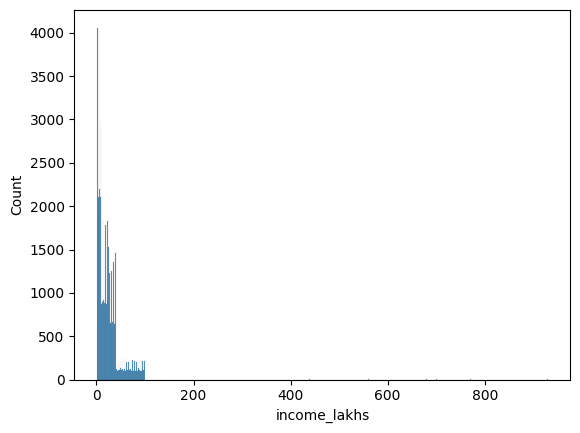

In [36]:
sns.histplot(df1.income_lakhs)

In [37]:
df.income_lakhs.quantile([0.25, 0.75])

0.25     7.0
0.75    31.0
Name: income_lakhs, dtype: float64

In [38]:
def get_iqr_bounds(col):
    Q1, Q3 = col.quantile([0.25, 0.75])
    IQR = Q3-Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return lower_bound, upper_bound

lower, upper = get_iqr_bounds(df1['income_lakhs'])
lower, upper

(-29.0, 67.0)

In [39]:
## we don't have to worry about the lower bound as anywats our minimun income is 1 lakh which is okay.

In [40]:
df[df.income_lakhs>upper].shape

(3560, 13)

In [41]:
quantile_threshold = df1.income_lakhs.quantile(0.999)
quantile_threshold

np.float64(100.0)

In [42]:
df2 = df1[df1.income_lakhs<=quantile_threshold].copy()
df2.describe()

,age,number_of_dependants,income_lakhs,annual_premium_amount
count,49908.000000,49908.000000,49908.000000,49908.000000
mean,34.401579,1.717640,22.889897,15765.739641
std,13.681604,1.492032,22.170699,8418.674061
min,18.000000,0.000000,1.000000,3501.000000
25%,22.000000,0.000000,7.000000,8608.000000
50%,31.000000,2.000000,17.000000,13928.000000
75%,45.000000,3.000000,31.000000,22270.500000
max,72.000000,5.000000,100.000000,43471.000000


In [43]:
## income 1->100 lakhs ->reasonable range

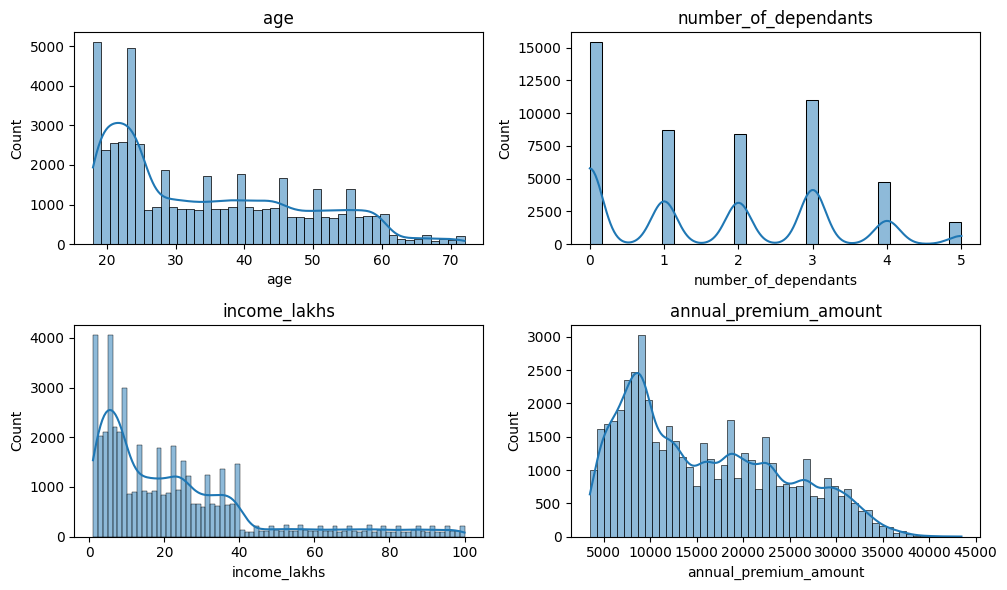

In [44]:
## visualizing the distribution of numeric datasets

fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(10, 6))

for i, column in enumerate(numeric_columns):
    ax = axs[i//2, i%2]  # Determines the position of the subplot in the grid
    sns.histplot(df2[column], kde=True, ax=ax)
    ax.set_title(column)

plt.tight_layout()
plt.show()

In [45]:
## most income datasets are right skewed

<Axes: xlabel='income_lakhs', ylabel='Count'>

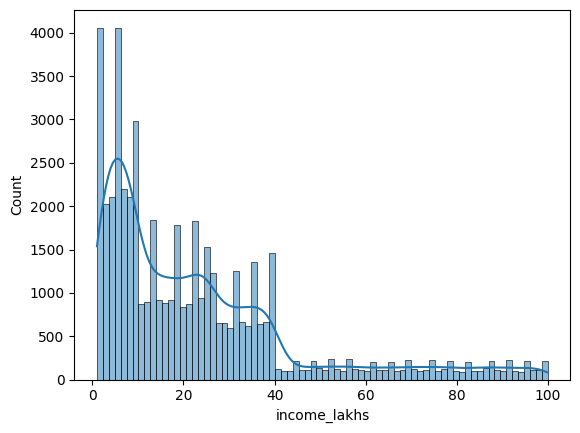

In [46]:
 sns.histplot(df2.income_lakhs, kde=True)

### Bivariate Analysis: Numeric Columns

<Axes: xlabel='age', ylabel='annual_premium_amount'>

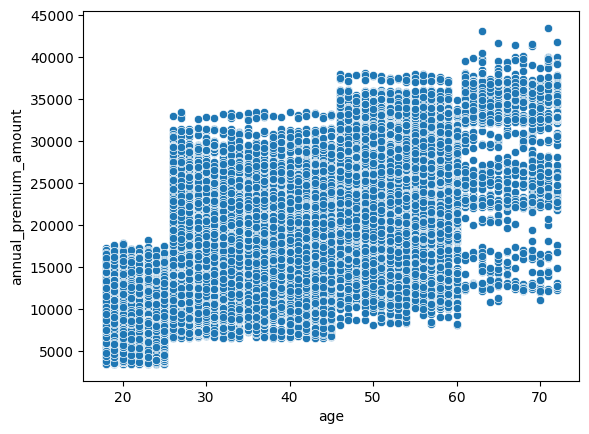

In [48]:
## scatterplot -> annual_premium_amount vs age

sns.scatterplot(df2, x = 'age', y = 'annual_premium_amount')

In [49]:
## we can se clusters here after observing carefully. 
## Also another observation-> as age increases, premium also increases. COMMON SENSE

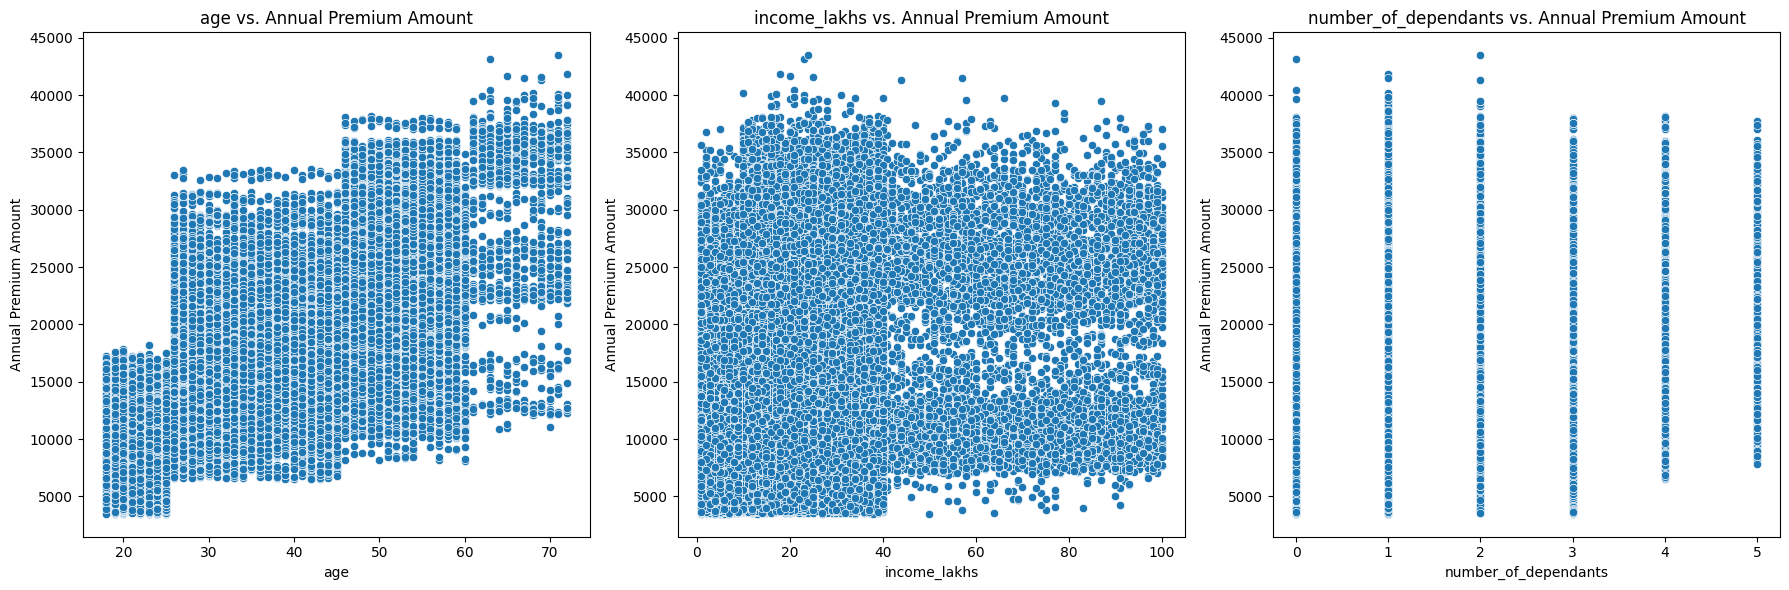

In [50]:
numeric_features = ['age', 'income_lakhs', 'number_of_dependants']

fig, axes = plt.subplots(1, len(numeric_features), figsize=(18, 6))  

for ax, column in zip(axes, numeric_features):
    sns.scatterplot(x=df2[column], y=df2['annual_premium_amount'], ax=ax)
    ax.set_title(f'{column} vs. Annual Premium Amount')
    ax.set_xlabel(column)
    ax.set_ylabel('Annual Premium Amount')

plt.tight_layout()  # Adjust layout
plt.show()

In [51]:
## not much correlation between income, premium and no of dependets, premium

##  Categorical Columns

In [53]:
categorical_cols = ['gender', 'region', 'marital_status', 'bmi_category', 'smoking_status', 'employment_status', 'income_level', 'medical_history', 'insurance_plan']
for col in categorical_cols:
    print(col, ":", df2[col].unique())

gender : ['Male' 'Female']
region : ['Northwest' 'Southeast' 'Northeast' 'Southwest']
marital_status : ['Unmarried' 'Married']
bmi_category : ['Normal' 'Obesity' 'Overweight' 'Underweight']
smoking_status : ['No Smoking' 'Regular' 'Occasional' 'Smoking=0' 'Does Not Smoke'
 'Not Smoking']
employment_status : ['Salaried' 'Self-Employed' 'Freelancer']
income_level : ['<10L' '10L - 25L' '> 40L' '25L - 40L']
medical_history : ['Diabetes' 'High blood pressure' 'No Disease'
 'Diabetes & High blood pressure' 'Thyroid' 'Heart disease'
 'High blood pressure & Heart disease' 'Diabetes & Thyroid'
 'Diabetes & Heart disease']
insurance_plan : ['Bronze' 'Silver' 'Gold']


In [54]:
##smoking_status : ['No Smoking' 'Regular' 'Occasional' 'Smoking=0' 'Does Not Smoke' 'Not Smoking'] -> problems

df2['smoking_status'].replace({
    'Not Smoking': 'No Smoking',
    'Does Not Smoke': 'No Smoking',
    'Smoking=0': 'No Smoking'
}, inplace=True)

df2['smoking_status'].unique()

C:\Users\Asus\AppData\Local\Temp\ipykernel_7232\98815810.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df2['smoking_status'].replace({


array(['No Smoking', 'Regular', 'Occasional'], dtype=object)

In [55]:
### Univariate Analysis: Categorical columns

In [56]:
pct_count = df2['gender'].value_counts(normalize = True)
pct_count

gender
Male      0.549631
Female    0.450369
Name: proportion, dtype: float64

<Axes: xlabel='gender'>

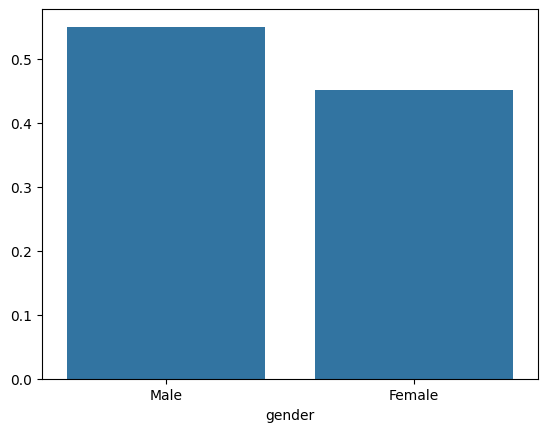

In [57]:
sns.barplot(x=pct_count.index, y=pct_count.values)

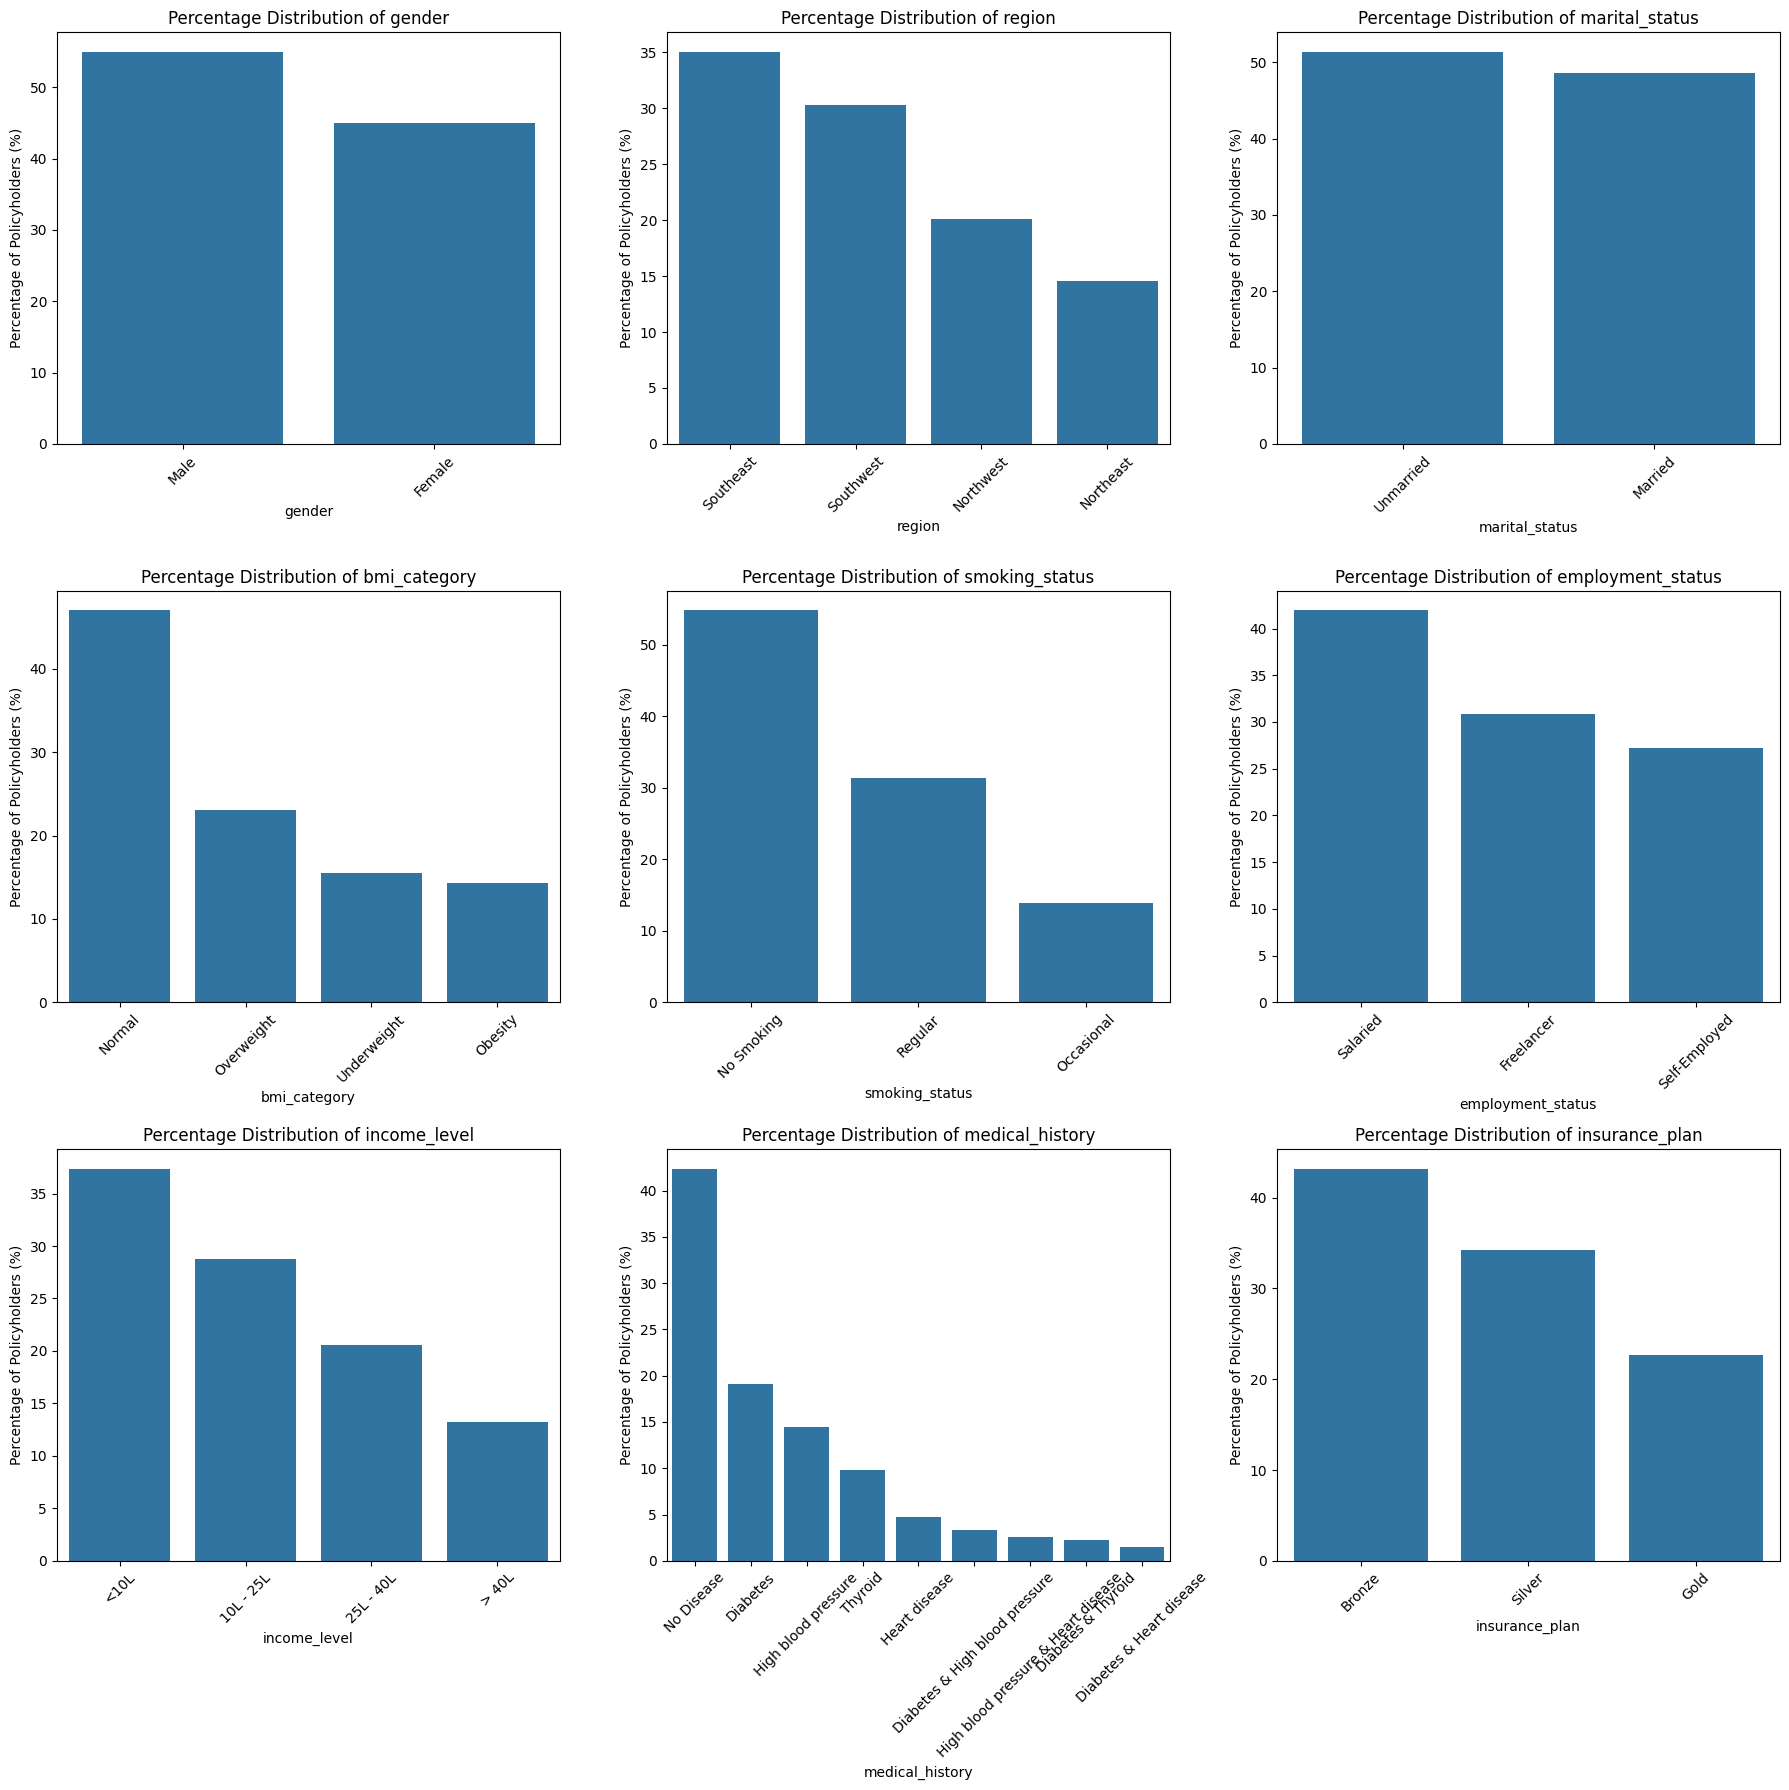

In [58]:
fig, axes = plt.subplots(3, 3, figsize=(18, 18))  
axes = axes.flatten()  # Flatten the 2D array of axes into 1D for easier iteration

for ax, column in zip(axes, categorical_cols):
    # Calculate the percentage distribution of each category
    category_counts = df2[column].value_counts(normalize=True) * 100  # normalize=True gives the relative frequencies
    
    # Plotting the distribution using barplot
    sns.barplot(x=category_counts.index, y=category_counts.values, ax=ax)
    ax.set_title(f'Percentage Distribution of {column}')
    ax.set_ylabel('Percentage of Policyholders (%)')
    ax.set_xlabel(column)  # Set xlabel to the column name for clarity
    ax.tick_params(axis='x', rotation=45)

plt.tight_layout()  
plt.show()

### Bivariate Analysis: Categorical columns

insurance_plan  Bronze  Gold  Silver
income_level                        
10L - 25L         5307  3880    5182
25L - 40L         3683  2840    3750
<10L             12226   931    5486
> 40L              329  3653    2641


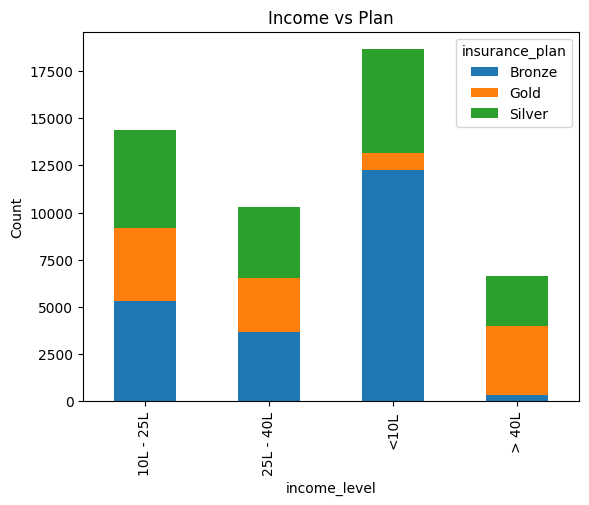

In [60]:
# Cross-tabulation of gender and smoking status
crosstab = pd.crosstab(df2.income_level, df2.insurance_plan)
print(crosstab)
crosstab.plot(kind = 'bar', stacked = True)
plt.title('Income vs Plan')
plt.ylabel('Count')
plt.show()

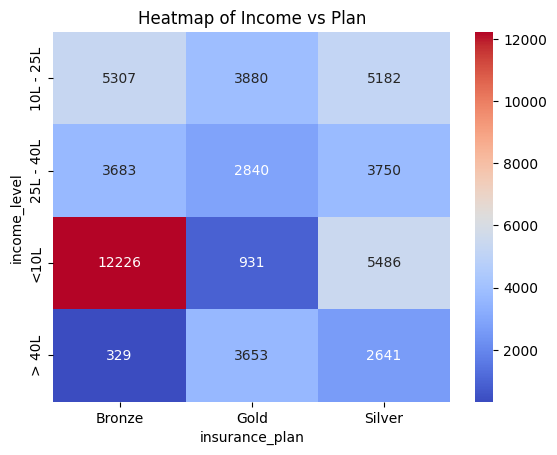

In [61]:
sns.heatmap(crosstab, annot=True, cmap='coolwarm',fmt="d")
plt.title('Heatmap of Income vs Plan')
plt.show()

### 3. Feature Engineering

In [63]:
df2.head()

,age,gender,region,marital_status,number_of_dependants,bmi_category,smoking_status,employment_status,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount
0,26,Male,Northwest,Unmarried,0,Normal,No Smoking,Salaried,<10L,6,Diabetes,Bronze,9053
1,29,Female,Southeast,Married,2,Obesity,Regular,Salaried,<10L,6,Diabetes,Bronze,16339
2,49,Female,Northeast,Married,2,Normal,No Smoking,Self-Employed,10L - 25L,20,High blood pressure,Silver,18164
3,30,Female,Southeast,Married,3,Normal,No Smoking,Salaried,> 40L,77,No Disease,Gold,20303
4,18,Male,Northeast,Unmarried,0,Overweight,Regular,Self-Employed,> 40L,99,High blood pressure,Silver,13365


In [64]:
df2.medical_history.unique()

array(['Diabetes', 'High blood pressure', 'No Disease',
       'Diabetes & High blood pressure', 'Thyroid', 'Heart disease',
       'High blood pressure & Heart disease', 'Diabetes & Thyroid',
       'Diabetes & Heart disease'], dtype=object)

In [65]:
## here we can calculate and assign some kind of risk score becaus ml models can't process this text values.
## more diseases -> more premium

In [66]:
## Define the risk scores for each condition.
## Logic used here is just an example. In real world, stakeholders decide what to do in situations like these.

risk_scores = {
    "diabetes": 6,
    "heart disease": 8,
    "high blood pressure":6,
    "thyroid": 5,
    "no disease": 0,
    "none":0
}

df2[['disease1', 'disease2']] = df2['medical_history'].str.split(" & ", expand=True).apply(lambda x: x.str.lower())
df2['disease1'].fillna('none', inplace=True)
df2['disease2'].fillna('none', inplace=True)
df2['total_risk_score'] = 0

for disease in ['disease1', 'disease2']:
    df2['total_risk_score'] += df2[disease].map(risk_scores)

# Normalize the risk score to a range of 0 to 1
max_score = df2['total_risk_score'].max()
min_score = df2['total_risk_score'].min()
df2['normalized_risk_score'] = (df2['total_risk_score'] - min_score) / (max_score - min_score)
df2.sample(20)

C:\Users\Asus\AppData\Local\Temp\ipykernel_7232\3519769614.py:14: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df2['disease1'].fillna('none', inplace=True)
C:\Users\Asus\AppData\Local\Temp\ipykernel_7232\3519769614.py:15: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, 

,age,gender,region,marital_status,number_of_dependants,bmi_category,smoking_status,employment_status,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount,disease1,disease2,total_risk_score,normalized_risk_score
34883,53,Male,Northwest,Married,2,Overweight,No Smoking,Self-Employed,25L - 40L,39,High blood pressure,Gold,28832,high blood pressure,none,6,0.428571
21698,43,Female,Northwest,Unmarried,1,Obesity,No Smoking,Self-Employed,<10L,6,No Disease,Bronze,11219,no disease,none,0,0.000000
4877,44,Female,Southwest,Married,3,Overweight,No Smoking,Salaried,10L - 25L,19,Diabetes,Gold,23887,diabetes,none,6,0.428571
46308,55,Male,Southwest,Married,3,Overweight,Occasional,Self-Employed,<10L,6,Diabetes,Silver,21832,diabetes,none,6,0.428571
16147,25,Female,Southeast,Unmarried,0,Normal,No Smoking,Freelancer,> 40L,47,No Disease,Silver,12921,no disease,none,0,0.000000
8135,56,Male,Southwest,Married,4,Normal,Regular,Salaried,<10L,2,Diabetes,Silver,21988,diabetes,none,6,0.428571
24037,21,Female,Southwest,Unmarried,1,Normal,No Smoking,Self-Employed,10L - 25L,19,No Disease,Bronze,6907,no disease,none,0,0.000000
48360,22,Female,Northeast,Unmarried,1,Normal,No Smoking,Self-Employed,10L - 25L,25,No Disease,Bronze,7341,no disease,none,0,0.000000
22151,35,Female,Northwest,Married,4,Normal,Regular,Salaried,<10L,1,High blood pressure & Heart disease,Bronze,15688,high blood pressure,heart disease,14,1.000000
49627,23,Female,Southwest,Unmarried,0,Obesity,No Smoking,Self-Employed,25L - 40L,34,No Disease,Bronze,6481,no disease,none,0,0.000000


### Label encoding text columns

In [68]:
df2.insurance_plan.unique

<bound method Series.unique of 0        Bronze
1        Bronze
2        Silver
3          Gold
4        Silver
          ...  
49995    Bronze
49996      Gold
49997    Bronze
49998    Bronze
49999    Silver
Name: insurance_plan, Length: 49908, dtype: object>

In [69]:
df2['insurance_plan'] = df2['insurance_plan'].map({'Bronze': 1, 'Silver': 2, 'Gold': 3})

In [70]:
df2.income_level.unique()

array(['<10L', '10L - 25L', '> 40L', '25L - 40L'], dtype=object)

In [71]:
df2['income_level'] = df2['income_level'].map({'<10L':1, '10L - 25L': 2, '25L - 40L':3, '> 40L':4})

In [72]:
df2.head()

,age,gender,region,marital_status,number_of_dependants,bmi_category,smoking_status,employment_status,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount,disease1,disease2,total_risk_score,normalized_risk_score
0,26,Male,Northwest,Unmarried,0,Normal,No Smoking,Salaried,1,6,Diabetes,1,9053,diabetes,none,6,0.428571
1,29,Female,Southeast,Married,2,Obesity,Regular,Salaried,1,6,Diabetes,1,16339,diabetes,none,6,0.428571
2,49,Female,Northeast,Married,2,Normal,No Smoking,Self-Employed,2,20,High blood pressure,2,18164,high blood pressure,none,6,0.428571
3,30,Female,Southeast,Married,3,Normal,No Smoking,Salaried,4,77,No Disease,3,20303,no disease,none,0,0.000000
4,18,Male,Northeast,Unmarried,0,Overweight,Regular,Self-Employed,4,99,High blood pressure,2,13365,high blood pressure,none,6,0.428571


### Label encoding text columns

In [74]:
nominal_cols = ['gender', 'region', 'marital_status', 'bmi_category', 'smoking_status', 'employment_status']
df3 = pd.get_dummies(df2, columns=nominal_cols, drop_first=True, dtype=int)
df3.head(3)

,age,number_of_dependants,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount,disease1,disease2,total_risk_score,...,region_Southeast,region_Southwest,marital_status_Unmarried,bmi_category_Obesity,bmi_category_Overweight,bmi_category_Underweight,smoking_status_Occasional,smoking_status_Regular,employment_status_Salaried,employment_status_Self-Employed
0,26,0,1,6,Diabetes,1,9053,diabetes,none,6,...,0,0,1,0,0,0,0,0,1,0
1,29,2,1,6,Diabetes,1,16339,diabetes,none,6,...,1,0,0,1,0,0,0,1,1,0
2,49,2,2,20,High blood pressure,2,18164,high blood pressure,none,6,...,0,0,0,0,0,0,0,0,0,1


## 3. Feature Selection

In [76]:
df3.info()

<class 'pandas.core.frame.DataFrame'>
Index: 49908 entries, 0 to 49999
Data columns (total 23 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   age                              49908 non-null  int64  
 1   number_of_dependants             49908 non-null  int64  
 2   income_level                     49908 non-null  int64  
 3   income_lakhs                     49908 non-null  int64  
 4   medical_history                  49908 non-null  object 
 5   insurance_plan                   49908 non-null  int64  
 6   annual_premium_amount            49908 non-null  int64  
 7   disease1                         49908 non-null  object 
 8   disease2                         49908 non-null  object 
 9   total_risk_score                 49908 non-null  int64  
 10  normalized_risk_score            49908 non-null  float64
 11  gender_Male                      49908 non-null  int64  
 12  region_Northwest       

In [77]:
df4 = df3.drop(['medical_history','disease1', 'disease2', 'total_risk_score'], axis=1)
df4.head(3)                

,age,number_of_dependants,income_level,income_lakhs,insurance_plan,annual_premium_amount,normalized_risk_score,gender_Male,region_Northwest,region_Southeast,region_Southwest,marital_status_Unmarried,bmi_category_Obesity,bmi_category_Overweight,bmi_category_Underweight,smoking_status_Occasional,smoking_status_Regular,employment_status_Salaried,employment_status_Self-Employed
0,26,0,1,6,1,9053,0.428571,1,1,0,0,1,0,0,0,0,0,1,0
1,29,2,1,6,1,16339,0.428571,0,0,1,0,0,1,0,0,0,1,1,0
2,49,2,2,20,2,18164,0.428571,0,0,0,0,0,0,0,0,0,0,0,1


#### Calculate VIF for Multicolinearity

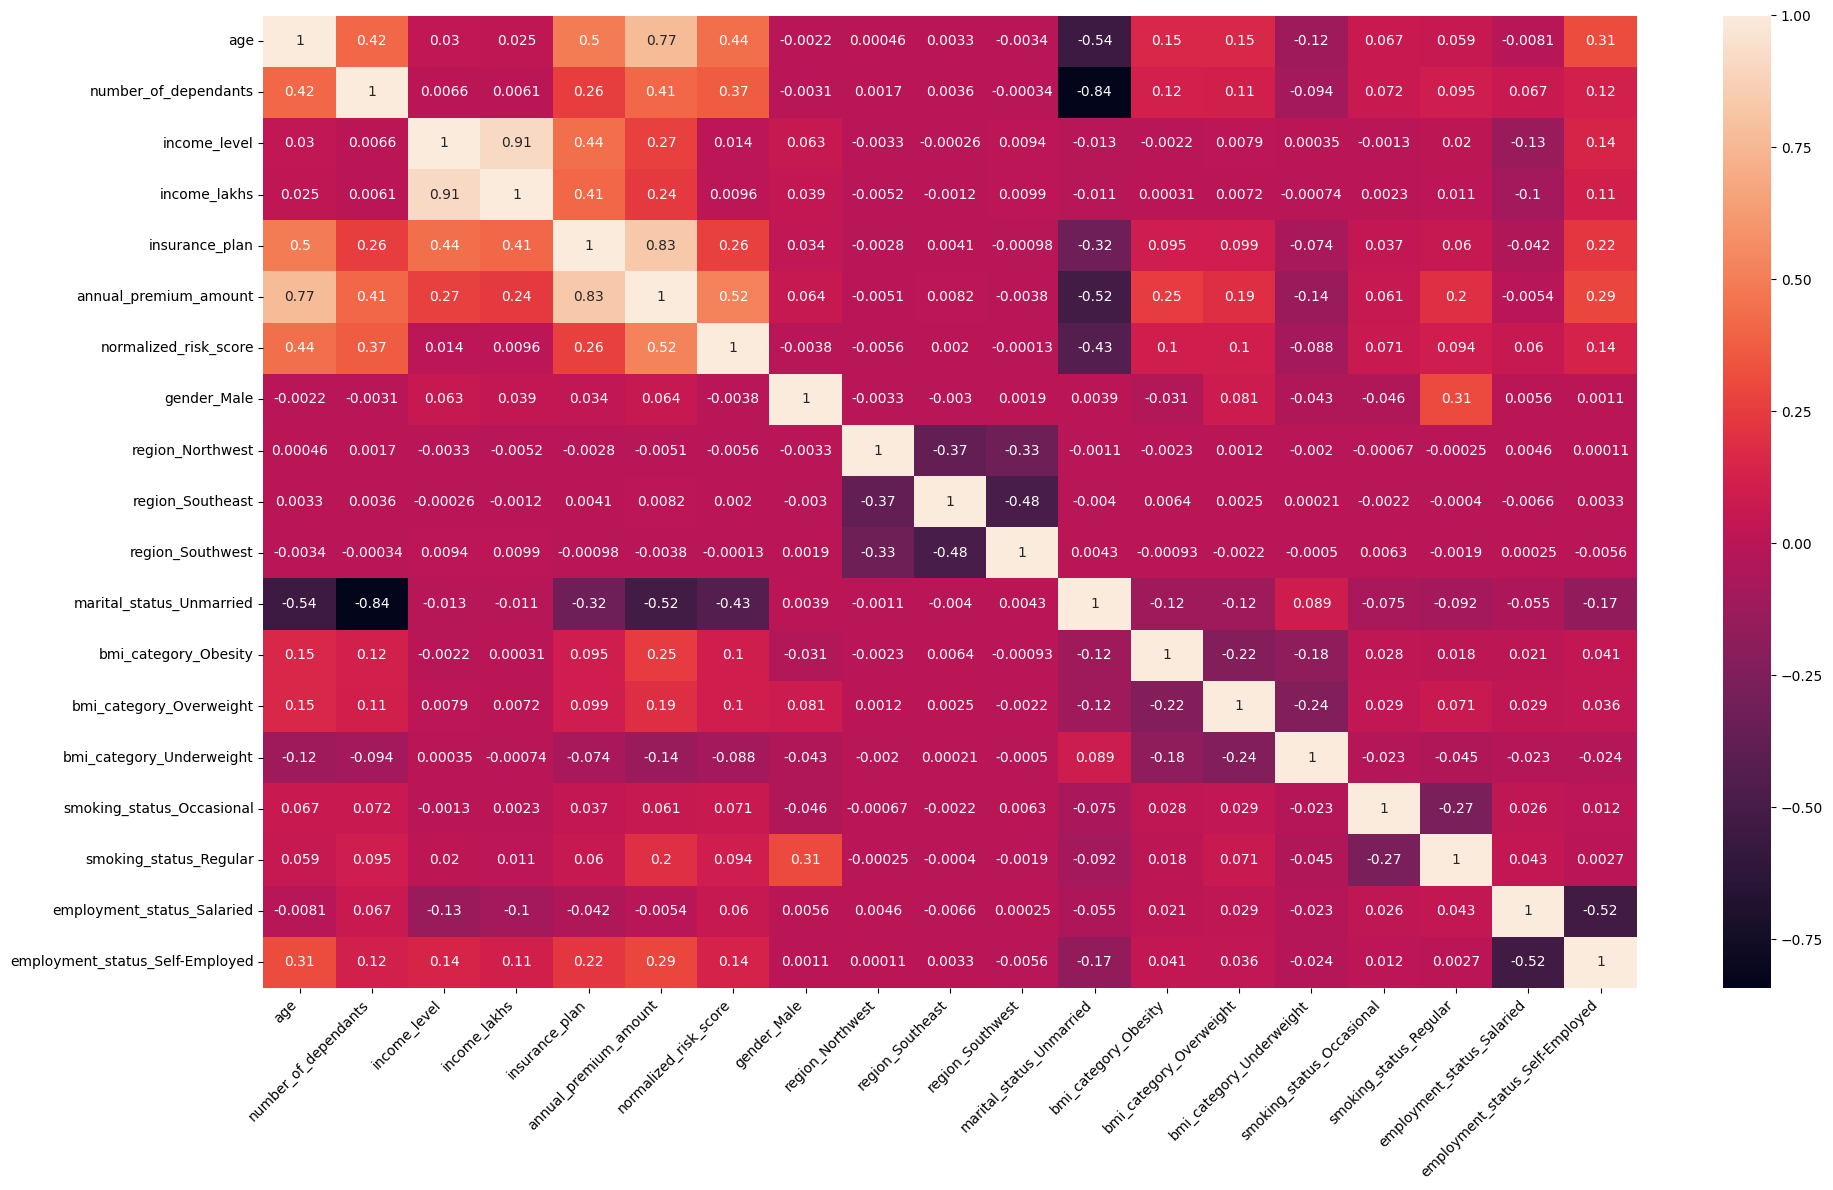

In [79]:
## correlation analysis
cm = df4.corr()

plt.figure(figsize=(20,12))
sns.heatmap(cm, annot=True)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

In [80]:
## feature scaling

X = df4.drop('annual_premium_amount', axis='columns')
y = df4['annual_premium_amount']

from sklearn.preprocessing import MinMaxScaler

cols_to_scale = ['age','number_of_dependants', 'income_level',  'income_lakhs', 'insurance_plan']
scaler = MinMaxScaler()

X[cols_to_scale] = scaler.fit_transform(X[cols_to_scale])
X.describe()

,age,number_of_dependants,income_level,income_lakhs,insurance_plan,normalized_risk_score,gender_Male,region_Northwest,region_Southeast,region_Southwest,marital_status_Unmarried,bmi_category_Obesity,bmi_category_Overweight,bmi_category_Underweight,smoking_status_Occasional,smoking_status_Regular,employment_status_Salaried,employment_status_Self-Employed
count,49908.000000,49908.000000,49908.000000,49908.000000,49908.000000,49908.000000,49908.000000,49908.00000,49908.000000,49908.000000,49908.000000,49908.000000,49908.000000,49908.000000,49908.000000,49908.000000,49908.000000,49908.000000
mean,0.303733,0.343528,0.365900,0.221110,0.397401,0.291831,0.549631,0.20093,0.350385,0.303038,0.513545,0.143183,0.231245,0.155326,0.138274,0.313857,0.419412,0.272041
std,0.253363,0.298406,0.349711,0.223946,0.392459,0.287420,0.497536,0.40070,0.477095,0.459576,0.499822,0.350263,0.421633,0.362219,0.345191,0.464064,0.493468,0.445015
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.074074,0.000000,0.000000,0.060606,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.240741,0.400000,0.333333,0.161616,0.500000,0.357143,1.000000,0.00000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.500000,0.600000,0.666667,0.303030,0.500000,0.428571,1.000000,0.00000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [81]:
## calculating VIF
from statsmodels.stats.outliers_influence import variance_inflation_factor

def calculate_vif(data):
    vif_df = pd.DataFrame()
    vif_df['Column'] = data.columns
    vif_df['VIF'] = [variance_inflation_factor(data.values,i) for i in range(data.shape[1])]
    return vif_df

In [82]:
calculate_vif(X)

,Column,VIF
0,age,4.567634
1,number_of_dependants,4.534650
2,income_level,12.450675
3,income_lakhs,11.183367
4,insurance_plan,3.584752
5,normalized_risk_score,2.687610
6,gender_Male,2.421496
7,region_Northwest,2.102556
8,region_Southeast,2.922414
9,region_Southwest,2.670666


In [83]:
calculate_vif(X.drop('income_level', axis="columns")) ## vif value after droppinh the column with highest vif value looks perfectly fine.

,Column,VIF
0,age,4.545825
1,number_of_dependants,4.526598
2,income_lakhs,2.480563
3,insurance_plan,3.445682
4,normalized_risk_score,2.687326
5,gender_Male,2.409980
6,region_Northwest,2.100789
7,region_Southeast,2.919775
8,region_Southwest,2.668314
9,marital_status_Unmarried,3.393718


In [84]:
# we will drop income_lakhs due to high VIF value
X_reduced = X.drop('income_level', axis="columns")

## 4. Model training    

In [86]:
X_train, X_test, y_train, y_test = train_test_split(X_reduced, y, test_size=0.30, random_state=10)

# shape of the X_train, X_test, y_train, y_test features
print("x train: ",X_train.shape)
print("x test: ",X_test.shape)
print("y train: ",y_train.shape)
print("y test: ",y_test.shape)

x train:  (34935, 17)
x test:  (14973, 17)
y train:  (34935,)
y test:  (14973,)


#### i. Linear Regression Model

In [88]:
model_lr = LinearRegression()
model_lr.fit(X_train, y_train)
test_score = model_lr.score(X_test, y_test)
train_score = model_lr.score(X_train, y_train)
train_score, test_score

(0.9282143576916762, 0.9280547230217837)

In [89]:
y_pred = model_lr.predict(X_test)

mse_lr = mean_squared_error(y_test, y_pred)
rmse_lr = np.sqrt(mse_lr)
print("Linear Regression ==> MSE: ", mse_lr, "RMSE: ", rmse_lr)

Linear Regression ==> MSE:  5165611.913027982 RMSE:  2272.798256121291


In [90]:
X_test.shape

(14973, 17)

In [91]:
X_test.head(1)

,age,number_of_dependants,income_lakhs,insurance_plan,normalized_risk_score,gender_Male,region_Northwest,region_Southeast,region_Southwest,marital_status_Unmarried,bmi_category_Obesity,bmi_category_Overweight,bmi_category_Underweight,smoking_status_Occasional,smoking_status_Regular,employment_status_Salaried,employment_status_Self-Employed
3598,0.481481,0.4,0.343434,0.5,0.428571,1,0,1,0,1,0,1,0,0,1,1,0


In [92]:
np.set_printoptions(suppress=True, precision=6)
model_lr.coef_

array([11160.926462,  -676.443991,  -514.229816, 12557.012936,
        4810.357702,   168.646662,   -35.719292,    39.96513 ,
         -24.652929,  -935.760611,  3387.911455,  1599.362268,
         391.171304,   735.912278,  2234.804712,   155.984674,
         415.903973])

In [93]:
feature_importance = model_lr.coef_ ## It tells how much important the features are for the final prediction. In LR, feature importance is simply coefficients.    

# Create a DataFrame for easier handling
coef_df = pd.DataFrame(feature_importance, index=X_train.columns, columns=['Coefficients'])

# Sort the coefficients for better visualization
coef_df = coef_df.sort_values(by='Coefficients', ascending=True)
coef_df

,Coefficients
marital_status_Unmarried,-935.760611
number_of_dependants,-676.443991
income_lakhs,-514.229816
region_Northwest,-35.719292
region_Southwest,-24.652929
region_Southeast,39.965130
employment_status_Salaried,155.984674
gender_Male,168.646662
bmi_category_Underweight,391.171304
employment_status_Self-Employed,415.903973


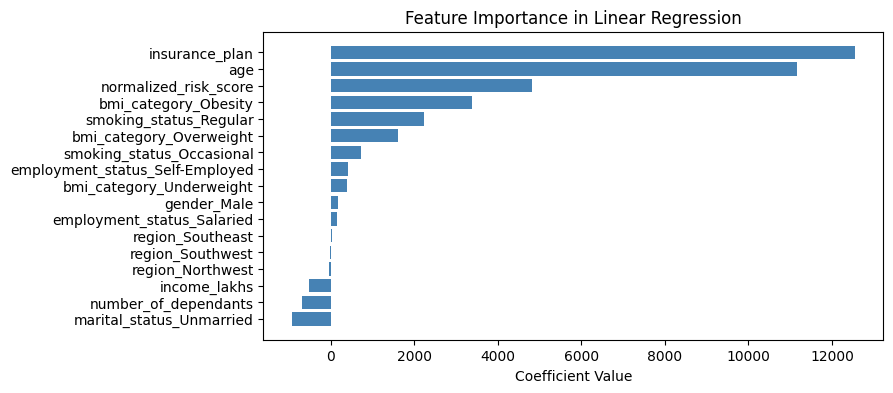

In [94]:
#Plotting
plt.figure(figsize=(8, 4))
plt.barh(coef_df.index, coef_df['Coefficients'], color='steelblue')
plt.xlabel('Coefficient Value')
plt.title('Feature Importance in Linear Regression')
plt.show()

#### ii. Ridge Regression Model

In [96]:
model_rg = Ridge(alpha=1)
model_rg.fit(X_train, y_train)
test_score = model_rg.score(X_test, y_test)
train_score = model_rg.score(X_train, y_train)
train_score, test_score

(0.9282143198366275, 0.9280541644640345)

In [97]:
y_pred = model_rg.predict(X_test)

mse_lr = mean_squared_error(y_test, y_pred)
rmse_lr = np.sqrt(mse_lr)
print("Ridge Regression ==> MSE: ", mse_lr, "RMSE: ", rmse_lr)

Ridge Regression ==> MSE:  5165652.017016523 RMSE:  2272.8070787060924


#### iii. XGBoost 

In [99]:
from xgboost import XGBRegressor

model_xgb = XGBRegressor(n_estimators=20, max_depth=3)
model_xgb.fit(X_train, y_train)
test_score = model_xgb.score(X_test, y_test)
train_score = model_xgb.score(X_train, y_train)
train_score, test_score

(0.978065013885498, 0.9782300591468811)

In [100]:
y_pred = model_xgb.predict(X_test)

mse_lr = mean_squared_error(y_test, y_pred)
rmse_lr = np.sqrt(mse_lr)
print("XGBoost Regression ==> MSE: ", mse_lr, "RMSE: ", rmse_lr)

XGBoost Regression ==> MSE:  1563064.1356043513 RMSE:  1250.2256338774819


In [ ]:
model_xgb = XGBRegressor()
param_grid = {
    'n_estimators': [20, 40, 50],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 4, 5],
}
random_search = RandomizedSearchCV(model_xgb, param_grid, n_iter=10, cv=3, scoring='r2', random_state=42, n_jobs=-1)
random_search.fit(X_train, y_train)
random_search.best_score_

In [ ]:
random_search.best_params_

In [ ]:
best_model = random_search.best_estimator_

In [ ]:
feature_importance = best_model.feature_importances_

# Creating a DataFrame for easier handling
coef_df = pd.DataFrame(feature_importance, index=X_train.columns, columns=['Coefficients'])

# Sorting the coefficients for better visualization
coef_df = coef_df.sort_values(by='Coefficients', ascending=True)

# Plotting
plt.figure(figsize=(8, 4))
plt.barh(coef_df.index, coef_df['Coefficients'], color='steelblue')
plt.xlabel('Coefficient Value')
plt.title('Feature Importance in XGBoost')
plt.show()

In [ ]:
## This feature importance has less explainability and interpretation then linear regression's. Its not actual coefficient like in LR where we can do direct math
## with the help of coefficients. In tree based model, the explainabilty more complex as compared to linear models.

## 5. Error Analysis

In [ ]:
## We can't just rely on r2 score and deploy the model. We need to find the margin of error for each of the sample we are running our prediction.

In [ ]:
y_pred = best_model.predict(X_test)

residuals = y_pred - y_test
residuals_pct = (residuals / y_test) * 100

results_df = pd.DataFrame({
    'actual': y_test, 
    'predicted': y_pred, 
    'diff': residuals, 
    'diff_pct': residuals_pct
})
results_df.head()

In [ ]:
sns.histplot(results_df.diff_pct, kde = True)
plt.show()

In [ ]:
## There are many records where we are predicting the premium upto 80 percent higher. Basically wrong output.

In [ ]:
extreme_error_threshold = 10  # We can adjust this threshold based on domain knowledge or requirements
extreme_results_df = results_df[np.abs(results_df['diff_pct']) > extreme_error_threshold]
extreme_results_df.head()

In [ ]:
extreme_results_df.shape

In [ ]:
results_df.shape

In [ ]:
extreme_errors_pct = extreme_results_df.shape[0]*100/X_test.shape[0]
extreme_errors_pct

In [ ]:
## Around 30 percent of the predictions are extreme errors. 
## Which means for 30% customers we will either overcharge or undercharge by 10% or more.

In [ ]:
extreme_results_df[abs(extreme_results_df.diff_pct)>50].sort_values("diff_pct",ascending=False).shape ## more than 50 percent error margin in extreme_df

In [ ]:
extreme_results_df[abs(extreme_results_df.diff_pct)>50].sort_values("diff_pct",ascending=False)

In [ ]:
##There will be about 549 customers whom we will overcharge or underchage by more than 50%

In [ ]:
extreme_results_df.index

In [ ]:
extreme_errors_df = X_test.loc[extreme_results_df.index]
extreme_errors_df.head()

In [ ]:
## these are the actual rows for which the model is giving wrong info

In [ ]:
for feature in X_test.columns:
    plt.figure(figsize=(10, 3))
    sns.histplot(extreme_errors_df[feature], color='red', label='Extreme Errors', kde=True)
    sns.histplot(X_test[feature], color='blue', label='Overall', alpha=0.5, kde=True)
    plt.legend()
    plt.title(f'Distribution of {feature} for Extreme Errors vs Overall')
    plt.show()

In [ ]:
## same shape = less error
## We can clearly see that in age columns, the errors are high for lower age group. The extreme errors are centered in lower age group

#### Reverse Scaling

In [ ]:
extreme_errors_df['income_level']=-1

In [ ]:
df_reversed = pd.DataFrame()
df_reversed[cols_to_scale] = scaler.inverse_transform(extreme_errors_df[cols_to_scale])
df_reversed.head()

In [ ]:
df_reversed.describe()

In [ ]:
sns.histplot(df_reversed.age)

In [ ]:
df_reversed['age'].quantile(0.97)

In [ ]:
## 97 percent of extreme errors have age<=25.
## This shows that majority of the extreme errors are coming from young age group (i.e. <25 years of age).
## We need to may be build a separate model for this segment

## 6. Model Segmentation